In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [2]:
class RSIBacktester(): 
    
    def __init__(self, symbol, periods, rsi_upper, rsi_lower, start, end, tc):
        self.symbol = symbol
        self.periods = periods
        self.rsi_upper = rsi_upper
        self.rsi_lower = rsi_lower
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "RSIBacktester(symbol = {}, RSI({}, {}, {}), start = {}, end = {})".format(self.symbol, self.periods, self.rsi_upper, self.rsi_lower, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("Daily_nifty_data.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["U"] = np.where(raw.price.diff() > 0, raw.price.diff(), 0) 
        raw["D"] = np.where(raw.price.diff() < 0, -raw.price.diff(), 0)
        raw["MA_U"] = raw.U.rolling(self.periods).mean()
        raw["MA_D"] = raw.D.rolling(self.periods).mean()
        raw["RSI"] = raw.MA_U / (raw.MA_U + raw.MA_D) * 100
        self.data = raw 
        
    def set_parameters(self, periods = None, rsi_upper = None, rsi_lower = None):
        ''' Updates RSI parameters and resp. time series.
        '''
        if periods is not None:
            self.periods = periods     
            self.data["MA_U"] = self.data.U.rolling(self.periods).mean()
            self.data["MA_D"] = self.data.D.rolling(self.periods).mean()
            self.data["RSI"] = self.data.MA_U / (self.data.MA_U + self.data.MA_D) * 100
            
        if rsi_upper is not None:
            self.rsi_upper = rsi_upper
            
        if rsi_lower is not None:
            self.rsi_lower = rsi_lower
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data.RSI > self.rsi_upper, -1, np.nan)
        data["position"] = np.where(data.RSI < self.rsi_lower, 1, data.position)
        data.position = data.position.fillna(0)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | RSI ({}, {}, {}) | TC = {}".format(self.symbol, self.periods, self.rsi_upper, self.rsi_lower, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, RSI):
        ''' Updates RSI parameters and returns the negative absolute performance (for minimization algorithm).
        '''
        self.set_parameters(int(RSI[0]), int(RSI[1]), int(RSI[2]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, periods_range, rsi_upper_range, rsi_lower_range):
        ''' Finds global maximum given the RSI parameter ranges.
        '''
        opt = brute(self.update_and_run, (periods_range, rsi_upper_range, rsi_lower_range), finish=None)
        return opt, -self.update_and_run(opt)
    
    

In [3]:
tester = RSIBacktester("Nifty50", periods = 14, rsi_upper = 80, rsi_lower = 20, start = "2008-01-01", end = "2022-07-01", tc = 0.0004)

In [4]:
tester

RSIBacktester(symbol = Nifty50, RSI(14, 80, 20), start = 2008-01-01, end = 2022-07-01)

In [5]:
tester.test_strategy()

(0.960031, -1.805862)

In [6]:
tester.results

,price,returns,U,D,MA_U,MA_D,RSI,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,,,
2008-01-21,5208.799805,-0.091046,0.000000,496.500000,13.871408,80.696429,14.668209,1.0,-0.000000,0.0,0.912976,1.000000
2008-01-22,4899.299805,-0.061257,0.000000,309.500000,11.367850,102.803571,9.956826,1.0,-0.061257,0.0,0.858728,0.940581
2008-01-23,5203.399902,0.060220,304.100098,0.000000,33.089286,102.742850,24.360425,0.0,0.059820,1.0,0.912029,0.998564
2008-01-24,5033.450195,-0.033207,0.000000,169.949707,26.250000,114.882115,18.599594,1.0,-0.000400,1.0,0.882241,0.998164
2008-01-25,5383.350098,0.067205,349.899902,0.000000,50.899972,114.882115,30.702938,0.0,0.066805,1.0,0.943570,1.067125
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24,15699.250000,0.009125,142.599609,0.000000,53.792829,115.957171,31.689443,0.0,0.000000,0.0,2.751696,0.960031
2022-06-27,15832.049805,0.008423,132.799805,0.000000,63.278530,105.014230,37.600269,0.0,0.000000,0.0,2.774972,0.960031
2022-06-28,15850.200195,0.001146,18.150391,0.000000,64.574986,100.721401,39.066181,0.0,0.000000,0.0,2.778154,0.960031


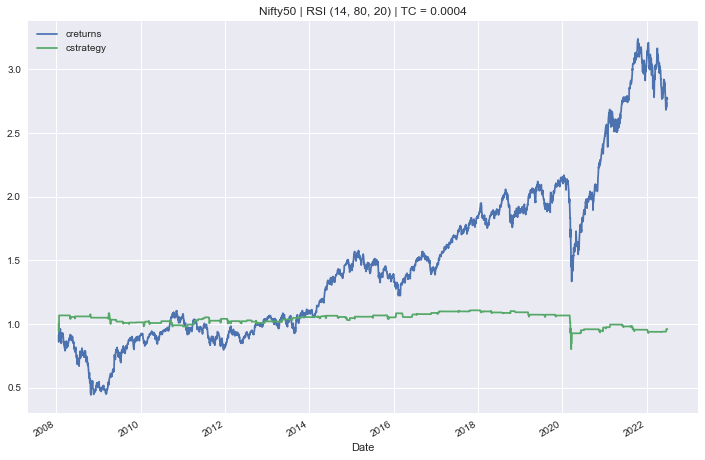

In [7]:
tester.plot_results()

In [8]:
tester.optimize_parameters((5, 20, 1), (65, 80, 1), (20, 35, 1))

(array([16., 78., 26.]), 1.255208)

In [9]:
tester.test_strategy()

(1.255208, -1.965712)

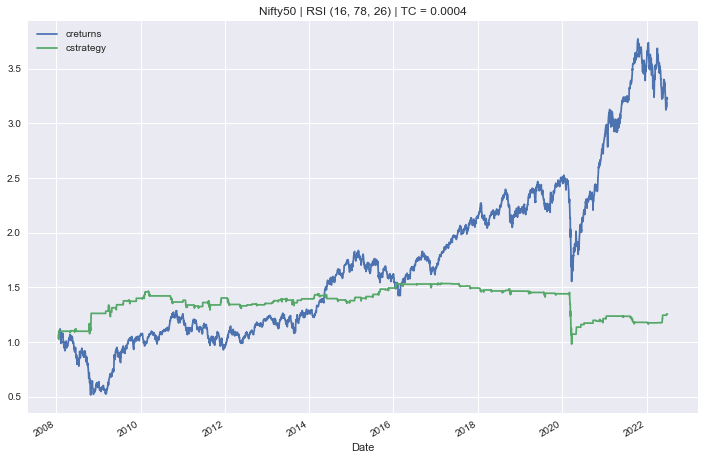

In [10]:
tester.plot_results()

In [11]:
tester.optimize_parameters((20, 50, 1), (75, 85, 1), (15, 25, 1))

(array([33., 76., 23.]), 1.356331)

In [12]:
tester.test_strategy()

(1.356331, -1.677165)

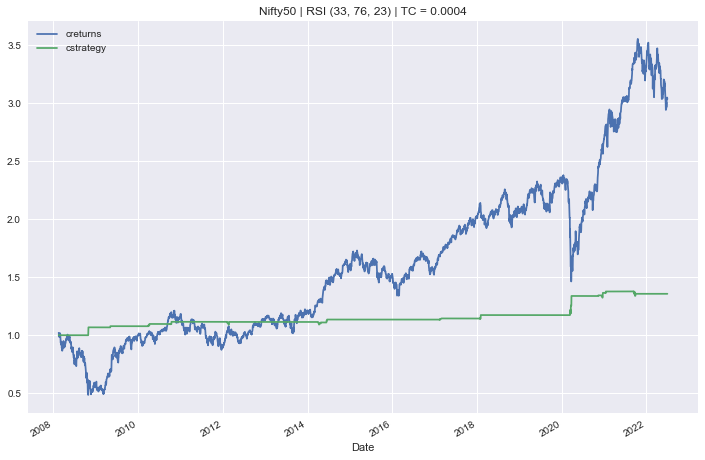

In [13]:
tester.plot_results()